In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
import glob
from scipy.io import wavfile
import librosa
import librosa.display


In [5]:
data_dir = '../../data/raw_data/zenodo.4008297/'
save_fp = '../../data/processed_data/specgram_db.npy'



In [6]:
data_fp = data_dir + 'B_ANI01_MC_FN_SIM01_301.wav'
data_fp


'../../data/raw_data/zenodo.4008297/B_ANI01_MC_FN_SIM01_301.wav'

visualize one sample

In [7]:
datasample, ratesample = librosa.load(data_fp, sr=None) 



/opt/homebrew/anaconda3/lib/python3.11/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


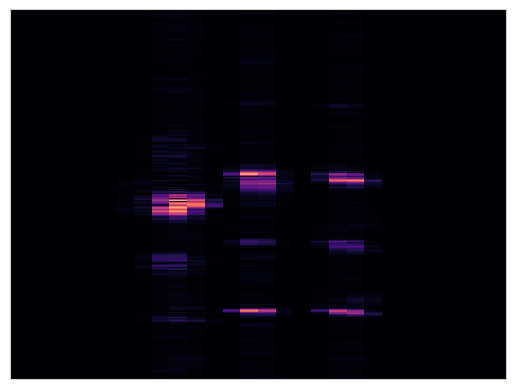

In [8]:
specgram_sample = librosa.stft(datasample)
librosa.display.specshow(specgram_sample)


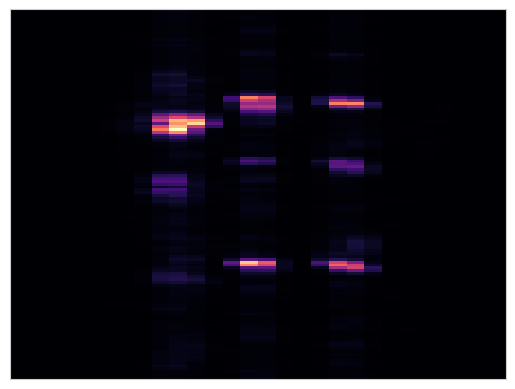

In [9]:
specmag_sample,_ = librosa.magphase(specgram_sample)
mel_scale_sgram_sample = librosa.feature.melspectrogram(S=specmag_sample,sr=ratesample)
librosa.display.specshow(mel_scale_sgram_sample)



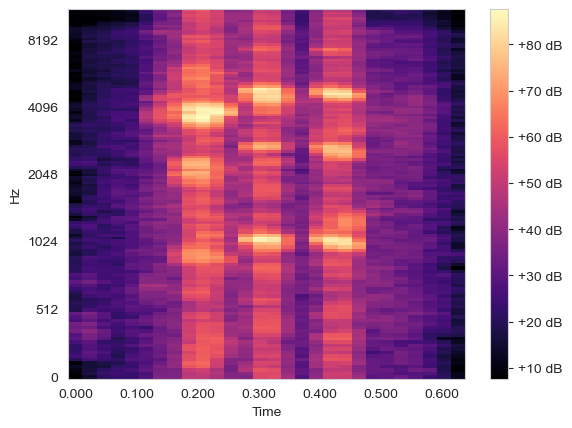

In [10]:
mel_spec_db_sample = librosa.amplitude_to_db(mel_scale_sgram_sample,ref=np.min)
librosa.display.specshow(mel_spec_db_sample, x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')



restore specgrams for all the data

In [11]:
#save figures for all the data
data_fps = glob.glob(os.path.join(data_dir, '*'))
arrs = []
for data_fp in data_fps:
    datalib, ratelib = librosa.load(data_fp, sr=None)
    specgram = librosa.stft(datalib)
    specmag,_ = librosa.magphase(specgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=specmag,sr=ratelib)
    mel_spec_db = librosa.amplitude_to_db(mel_scale_sgram,ref=np.min)
    arrs.append(mel_spec_db)
    

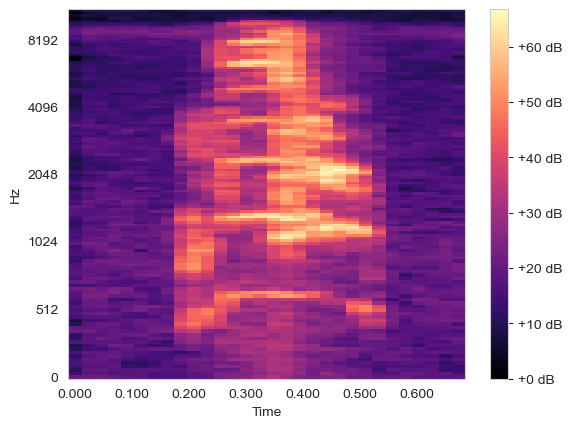

In [12]:
##just to check

librosa.display.specshow(arrs[5], x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')


In [13]:
shapes0 = [_.shape[0] for _ in arrs]
max_shape0 = np.max(shapes0) ##this is a bit unnecessary because this dimension is the same for all the data, just trying to be consistent with the other dimension
shapes1 = [_.shape[1] for _ in arrs]
max_shape1 = np.max(shapes1)+1 ##I added one for this just to make sure all rows are added 0 (just to make recover easier)


In the cell below, I filled in with "-1" instead of "0", because I'm afraid adding zeros whould change the figure, so I added -1 because -1 wasn't there in the original data. This should be good for future convenience to remove it.


In [14]:
spec_data = []
for i in range(len(arrs)):
    spec_data.append(np.pad(arrs[i], ((0, 0), (max_shape0-arrs[i].shape[0], max_shape1 - arrs[i].shape[1])), mode='constant',constant_values=-1))

spec_data = np.array(spec_data) ##transfered it to numpy array
    

In [15]:
spec_data.shape


(440, 128, 64)

In [16]:
np.save(save_fp,spec_data)

Load data

In [17]:

##let's try to see how to recover the data without -1. 
spec_load = np.load(save_fp)

arrs_load = []
for i in range(spec_load.shape[0]):
    unpadded_indice = np.argmax(spec_load[i][0] == -1)##I have no idea why this should be argmax, but it works
    #print(unpadded_indice)
    unpadded_array = spec_load[i][:, :unpadded_indice]
    arrs_load.append(unpadded_array)

In [18]:
#for i in range(len(arrs)):
    #print(arrs[i]-arrs_load[i])
    
##okay, recovered!!

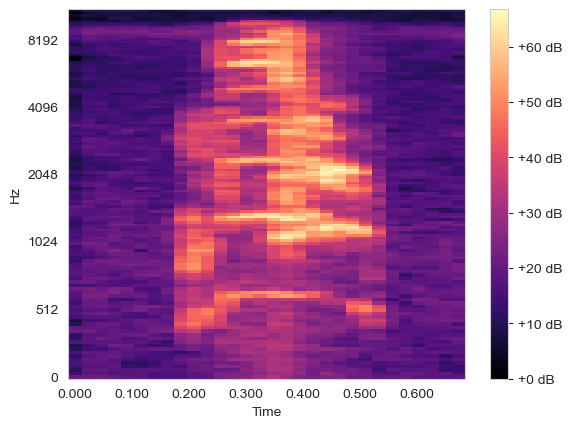

In [19]:
librosa.display.specshow(arrs_load[5],x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')



But perhaps filled with 0 is also fine, because "0" present total silence. Here is data filled with zeros.

In [20]:
spec_data0 = []
for i in range(len(arrs)):
    spec_data0.append(np.pad(arrs[i], ((0, 0), (max_shape0-arrs[i].shape[0], max_shape1 - arrs[i].shape[1])), mode='constant',constant_values=0))

spec_data0 = np.array(spec_data) ##transfered it to numpy array

but if you just store it and not recover to the original shape, the specgram will not look good (see below), so let's perhaps stay with the data filled with -1

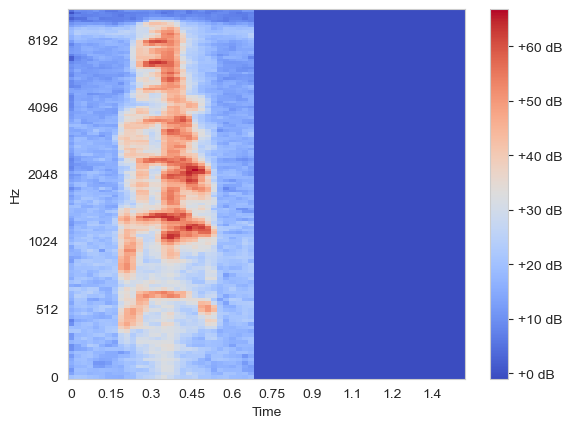

In [21]:
librosa.display.specshow(spec_data0[5], x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')